<a href="https://colab.research.google.com/github/martostwo/Recurrent_Neural_Network_TimeSeries_Forecasting/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install & Import

In [ ]:
!pip install ta
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29103 sha256=b2ea73876d8dbd03a9ec53d57e8c65d7d0d179d6640fec25d0be1d52e42467dc
  Stored in directory: /root/.cache/pip/wheels/6a/76/03/7f785aaa50b9c6ec7e3fd105a62c1b2c45a034512d51e024a9
Successfully built ta
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 KB 4.5 MB/s eta 0:00:00
     ━━

#Dark Mode

In [ ]:
#Module Import:
import pandas as pd;
import numpy as np;
import warnings;
import yfinance as yf;
import ta;
import matplotlib.pyplot as plt;
from matplotlib import cycler;
plt.style.use('seaborn');
warnings.filterwarnings("ignore");

#Dark mode for Graphics:
colors = cycler(
    'color',
    [
    '#669FEE','#66EE91', '#9988DD',
    '#EECC55', '#88BB44', '#FFBBBB'
    ]
);

plt.rc('figure', facecolor = '#313233');
plt.rc('axes', facecolor = "#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor = 'gray');

plt.rc('grid', color='474A4A', linestyle='solid');
plt.rc('xtick', color='gray');
plt.rc('ytick', direction='out', color='gray');
plt.rc('legend', facecolor="#313233", edgecolor="#313233");
plt.rc("text", color="#C9C9C9");
plt.rc('figure', facecolor='#313233');

<ipython-input-2-e0d92d8f87f3>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn');


#Feature Selection

In [ ]:
def yf_preprocessing(ticker):
  df = yf.download(ticker, start="1990-01-01")
  df.columns = ["open", "high", "low", "close", "adj close", "volume"]
  df.index.name = "date"
  return df

def yf_feature(df):

    #Copiamos el DataFrame para evitar interferencias en los datos:
    df_copy = df.copy()

    #creamos el retorno:
    df_copy["returns"] = df_copy["close"].pct_change(1)

    #price
    df_copy["op"] = df_copy["open"].shift(1)
    df_copy["hi"] = df_copy["high"].shift(1)
    df_copy["lo"] = df_copy["low"].shift(1)
    df_copy["clo"] = df_copy["close"].shift(1)

    #Volume
    df_copy["vol"] = df_copy["volume"].shift(1)

    #Creamos las SMAs:
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)

    #Creamos la volatilidad:
    df_copy["MSD 15"] = df_copy["returns"].rolling(15).std().shift(1)
    df_copy["MSD 60"] = df_copy["returns"].rolling(60).std().shift(1)

    #creamos VWAP:
    vwap = ta.volume.VolumeWeightedAveragePrice(
        high=df['high'],
        low=df['low'],
        close=df['close'],
        volume=df['volume'],
        window=5  # periodo de tiempo para el cálculo del VWAP
    )
    df_copy["vwap"] = vwap.vwap.shift(1)

    #Creamos el RSI:
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window = 5, fillna = False)
    df_copy["rsi"] = RSI.rsi().shift(1)

    return df_copy.dropna();

#Data Split

In [ ]:
df = yf_preprocessing("^GSPC")
df = yf_feature(df)
df

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,adj close,volume,returns,op,hi,lo,clo,vol,SMA 15,SMA 60,MSD 15,MSD 60,vwap,rsi
date,,,,,,,,,,,,,,,,,,
1990-03-29,342.000000,342.070007,339.769989,340.790009,340.790009,132190000,-0.003538,341.500000,342.579987,340.600006,342.000000,1.423000e+08,339.240000,336.063168,0.007200,0.008790,338.536699,66.096091
1990-03-30,340.790009,341.410004,338.209991,339.940002,339.940002,139340000,-0.002494,342.000000,342.070007,339.769989,340.790009,1.321900e+08,339.274668,335.763668,0.006848,0.008794,339.594760,57.090372
1990-04-02,339.940002,339.940002,336.329987,338.700012,338.700012,124360000,-0.003648,340.790009,341.410004,338.209991,339.940002,1.393400e+08,339.408669,335.501501,0.006618,0.008738,340.201172,50.989736
1990-04-03,338.700012,343.760010,338.700012,343.640015,343.640015,154310000,0.014585,339.940002,339.940002,336.329987,338.700012,1.243600e+08,339.410669,335.276501,0.006677,0.008666,340.200000,42.674302
1990-04-04,343.640015,344.119995,340.399994,341.089996,341.089996,159530000,-0.007421,338.700012,343.760010,338.700012,343.640015,1.543100e+08,339.920003,335.107334,0.007270,0.008862,340.644635,68.365424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-10,3912.770020,3934.050049,3846.320068,3861.590088,3861.590088,5518190000,-0.014478,3998.659912,4017.810059,3908.699951,3918.320068,4.445260e+09,4001.076009,3981.507674,0.010245,0.010895,4004.871363,26.406767
2023-03-13,3835.120117,3905.050049,3808.860107,3855.760010,3855.760010,6558020000,-0.001510,3912.770020,3934.050049,3846.320068,3861.590088,5.518190e+09,3985.821354,3979.358175,0.010295,0.010888,3968.139869,19.143202
2023-03-14,3894.010010,3937.290039,3873.629883,3919.290039,3919.290039,5665870000,0.016477,3835.120117,3905.050049,3808.860107,3855.760010,6.558020e+09,3970.932682,3976.626676,0.010309,0.010841,3922.768863,18.489861


#Standardization

Divide into training and test/validation sets.

In [ ]:
#Percentage train set
split = int(0.85*len(df))
split_val = int(0.95*len(df))

#Train set
x_train = df[['vwap','rsi','SMA 15','SMA 60','MSD 15','MSD 60','op','hi','lo','clo','vol']].iloc[:split,:]
y_train = df[['returns']].iloc[:split,:]

#Validation set
x_val = df[['vwap','rsi','SMA 15','SMA 60','MSD 15','MSD 60','op','hi','lo','clo','vol']].iloc[split:split_val,:]
y_val = df[['returns']].iloc[split:split_val,:]

#Test set
x_test = df[['vwap','rsi','SMA 15','SMA 60','MSD 15','MSD 60','op','hi','lo','clo','vol']].iloc[split_val:,:]
y_test = df[['returns']].iloc[split_val:,:]

#Standardization
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

#Estandarizamos conjunto de entrenamiento
x_train_sc = sc.fit_transform(x_train)

#Estandarizamos conjunto de testing
x_val_sc = sc.transform(x_val)

#Estandarizamos conjunto de testing
x_test_sc = sc.transform(x_test)

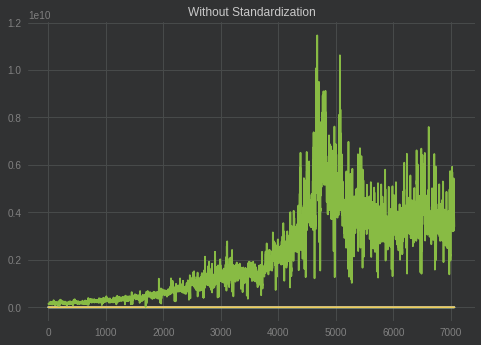

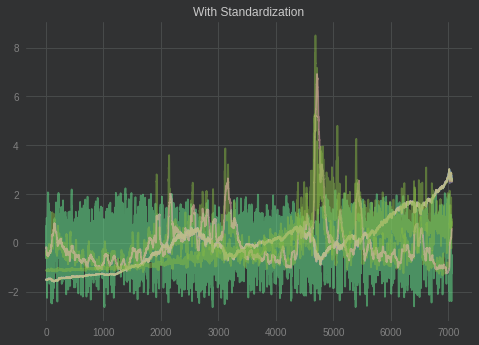

In [ ]:
#Graficamos los datos con y sin standarización para
#ver la diferencia de escala y cómo queda trás el proceso:

plt.plot(x_train.values);
plt.title("Without Standardization");
plt.show();

plt.plot(x_train_sc, alpha=0.5);
plt.title("With Standardization");
plt.show();


#Transform 2D array to 3D

In [ ]:
def X_3d_RNN(X_s, y_s, lag):

    # Verificación simple de longitudes
    if len(X_s) != len(y_s):
        print("Warnings")

    # Creamos la variable X_train
    X_train = []
    for variable in range(0, X_s.shape[1]):
        X = []
        for i in range(lag, X_s.shape[0]):
            X.append(X_s[i-lag:i, variable])
        X_train.append(X)
    X_train, np.array(X_train)
    X_train = np.swapaxes(np.swapaxes(X_train, 0, 1), 1, 2)

    # Creamos la variable y_train
    y_train = []
    for i in range(lag, y_s.shape[0]):
        y_train.append(y_s[i, :].reshape(-1,1).transpose())
    y_train = np.concatenate(y_train, axis=0)
    return X_train, y_train

In [ ]:
lag = 15
x_train_3d, y_train_3d = X_3d_RNN(x_train_sc, y_train.values, lag)
x_val_3d, y_val_3d = X_3d_RNN(x_val_sc, y_val.values, lag)
x_test_3d, y_test_3d = X_3d_RNN(x_test_sc, y_test.values, lag)

In [ ]:
print(f"Shape of training set: {x_train_3d.shape}")
print(f"Shape of validation set: {x_val_3d.shape}")
print(f"Shape of test set: {x_test_3d.shape}")

Shape of training set: (7044, 15, 11)
Shape of validation set: (815, 15, 11)
Shape of test set: (401, 15, 11)


#RNN

In [ ]:
from tensorflow import keras
from keras import layers

def build_model(input_shape, LSTM_units = 10, dropout = 0.2, GRU_units = 100, Dense_units = 125):

  #Model:
  inputs = layers.Input(shape = input_shape)
  x = inputs
  x = layers.LSTM(LSTM_units, return_sequences = True)(x)
  x = layers.Dropout(dropout)(x)
  x = layers.GRU(GRU_units, return_sequences = False)(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Dense(Dense_units, activation = "relu")(x)
  outputs = layers.Dense(1)(x)

  return keras.Model(inputs, outputs)

Build and train the model

In [ ]:
input_shape = x_train_3d.shape[1:]

model = build_model(input_shape)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam()
)

#model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=5, \
    restore_best_weights=True)]

model.fit(
    x_train_3d,
    y_train_3d,
    validation_data = (x_val_3d, y_val_3d),
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)


Epoch 1/200
111/111 [==============================] - 10s 45ms/step - loss: 6.5020e-04 - val_loss: 2.4606e-04
Epoch 2/200
111/111 [==============================] - 5s 45ms/step - loss: 2.3012e-04 - val_loss: 3.9434e-04
Epoch 3/200
111/111 [==============================] - 4s 34ms/step - loss: 1.9653e-04 - val_loss: 2.6350e-04
Epoch 4/200
111/111 [==============================] - 4s 35ms/step - loss: 1.6509e-04 - val_loss: 2.2497e-04
Epoch 5/200
111/111 [==============================] - 5s 47ms/step - loss: 1.5737e-04 - val_loss: 2.2087e-04
Epoch 6/200
111/111 [==============================] - 4s 34ms/step - loss: 1.4801e-04 - val_loss: 2.1544e-04
Epoch 7/200
111/111 [==============================] - 4s 34ms/step - loss: 1.4623e-04 - val_loss: 2.1827e-04
Epoch 8/200
111/111 [==============================] - 5s 49ms/step - loss: 1.4166e-04 - val_loss: 2.4662e-04
Epoch 9/200
111/111 [==============================] - 4s 34ms/step - loss: 1.4087e-04 - val_loss: 2.3866e-04
Epoch 10/

<Axes: >

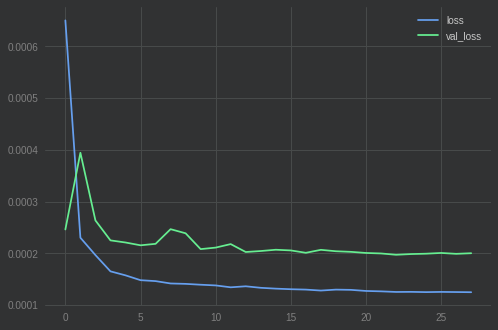

In [ ]:
pd.DataFrame(model.history.history).plot()

Finally, we evaluate the model with RMSE.

In [ ]:
from sklearn import metrics

pred = model.predict(x_test_3d)
score = np.sqrt(metrics.mean_squared_error(pred,y_test_3d))
print("Score (RMSE): {}".format(score))

13/13 [==============================] - 1s 6ms/step
Score (RMSE): 0.01358931244976306


In [ ]:
# Create predictions for the whole dataset
y_pred_train = np.concatenate((np.zeros([lag,1]), model.predict(x_train_3d)), axis=0)

y_pred_val = np.concatenate((np.zeros([lag,1]), model.predict(x_val_3d)), axis=0)

y_pred_test = np.concatenate((np.zeros([lag,1]), model.predict(x_test_3d)), axis=0)

df["prediction"] = np.concatenate((y_pred_train, y_pred_val, y_pred_test), axis=0)

#Calculamos la estrategia:
df["strategy"] = df["returns"]*np.sign(df["prediction"].shift(1));

13/13 [==============================] - 0s 9ms/step


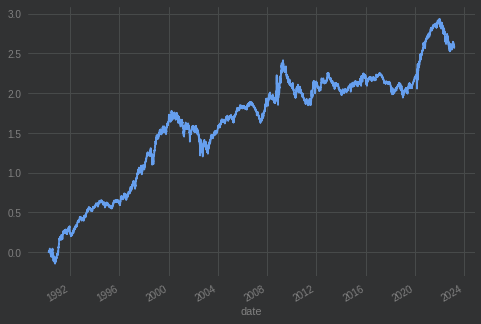

In [ ]:
df["strategy"].iloc[:].cumsum().plot()
plt.show(); 